In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv


In [2]:
is_test = False

In [3]:
calender = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv")
sell_price = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sell_prices.csv")
sales_train_val = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv")
smp_submission = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sample_submission.csv")

# 전처리

In [4]:
# sales_train_val
key = sales_train_val['item_id'] + '_' + sales_train_val['store_id']
sales_train_val = sales_train_val.iloc[:,6:]
sales_train_val.columns = list(map(lambda x: dict(zip(calender['d'], calender['date']))[x], sales_train_val.columns))
sales_train_val = sales_train_val.iloc[:,-1395:]

In [5]:
calender['is_weekend'] = calender['weekday'].apply(lambda x: 1 if (x=='Saturday')or(x=='Sunday') else 0)
calender['holi_event'] = calender['event_name_1'].apply(lambda x: 1 if not pd.isnull(x) and x in ['PresidentDay', 'MemorialDay', 'IndependenceDay', 'LaborDay', 'ColumnbusDay', 'VeteransDay', 'Thanksgiving', 'Christmas', 'NewYear', 'MartinLutherKingDay'] else 0)
calender['is_event'] = calender['event_name_1'].apply(lambda x: 1 if not pd.isnull(x) else 0)
calender.drop(['weekday', 'd', 'event_name_1', 'event_type_1','event_name_2','event_type_2'], axis=1, inplace=True)
calender

,date,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,is_weekend,holi_event,is_event
0,2011-01-29,11101,1,1,2011,0,0,0,1,0,0
1,2011-01-30,11101,2,1,2011,0,0,0,1,0,0
2,2011-01-31,11101,3,1,2011,0,0,0,0,0,0
3,2011-02-01,11101,4,2,2011,1,1,0,0,0,0
4,2011-02-02,11101,5,2,2011,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,5,6,2016,0,1,1,0,0,0
1965,2016-06-16,11620,6,6,2016,0,0,0,0,0,0
1966,2016-06-17,11620,7,6,2016,0,0,0,0,0,0
1967,2016-06-18,11621,1,6,2016,0,0,0,1,0,0


In [6]:
sell_price['key'] = sell_price['item_id'] + '_' + sell_price['store_id'] 
sell_price.drop(['store_id', 'item_id'], axis=1, inplace=True)

# Modeling

In [7]:
my_valset_cal = calender[1885:1913].drop('date', axis=1)
valset_cal = calender[1913:1941].drop('date', axis=1)
testset_cal =calender[1941:].drop('date', axis=1)
my_valset_y = sales_train_val.iloc[:,-28:]

In [8]:
import datetime
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [9]:
if is_test:
    sales_train_val = sales_train_val.iloc[:,:100]

In [10]:
n_clusters = 1000
km = KMeans(n_clusters = n_clusters, random_state = 42)
cluster = km.fit_predict(sales_train_val)

In [11]:
cols_order = []
val_result = []
test_result = []
my_val_result = []
print('Start', datetime.datetime.now())
for i in range(n_clusters): # 'date' 제외
    # for my validation
    tmp = sales_train_val.copy()
    sales_train_val = sales_train_val.iloc[:,:-28]
    trainset = pd.DataFrame({'key': np.repeat(key[cluster==i], len(sales_train_val.columns)),
                             'date': list(sales_train_val.columns)*sum(cluster==i),
                            'sales': np.hstack(np.array(sales_train_val)[cluster==i])})\
                .merge(calender, how='left', on='date').merge(sell_price, how='left', on=['key', 'wm_yr_wk']).fillna(-1)
    sell_price_tmp = sell_price[['wm_yr_wk', 'sell_price']][sell_price['key'].isin(key[cluster==i])]
    sell_price_tmp['sort_key'] = list(range(len(sell_price_tmp)))
    my_valset = my_valset_cal.merge(sell_price_tmp, how='left', on= 'wm_yr_wk').sort_values(['sort_key', 'wm_yr_wk', 'wday']).drop('sort_key', axis=1)
    
    trainset.drop(['key', 'date'], axis=1, inplace=True)
    trainset.fillna(-1, inplace=True)
    
    lgbm = lgb.LGBMRegressor( n_estimators=1024,
                               num_leaves=16,
                               bagging_fraction = 0.9,
                               feature_fraction = 0.7,
                               feature_fraction_seed=9,
                               bagging_seed=9,
                               learning_rate=0.05,
                               bagging_freq = 20,
                               max_bin = 32,
                               min_data_in_leaf = 2,
                               min_child_samples=20,
                               min_sum_hessian_in_leaf = 1,
                               n_jobs = -1,
                               random_state=5)
    lgbm.fit(X=trainset.drop('sales', axis=1), y=trainset['sales'])    
    my_val_result.append(lgbm.predict(my_valset))
    
    # for the leaderboard
    sales_train_val = tmp.copy()
    trainset = pd.DataFrame({'key': np.repeat(key[cluster==i], len(sales_train_val.columns)),
                             'date': list(sales_train_val.columns)*sum(cluster==i),
                            'sales': np.hstack(np.array(sales_train_val)[cluster==i])})\
                .merge(calender, how='left', on='date').merge(sell_price, how='left', on=['key', 'wm_yr_wk']).fillna(-1)
    sell_price_tmp = sell_price[['wm_yr_wk', 'sell_price']][sell_price['key'].isin(key[cluster==i])]
    sell_price_tmp['sort_key'] = list(range(len(sell_price_tmp)))
    valset = valset_cal.merge(sell_price_tmp, how='left', on= 'wm_yr_wk').sort_values(['sort_key', 'wm_yr_wk', 'wday']).drop('sort_key', axis=1)
    testset = testset_cal.merge(sell_price_tmp, how='left', on= 'wm_yr_wk').sort_values(['sort_key', 'wm_yr_wk', 'wday']).drop('sort_key', axis=1)

    trainset.drop(['key', 'date'], axis=1, inplace=True)
    trainset.fillna(-1, inplace=True)

    lgbm.fit(X=trainset.drop('sales', axis=1), y=trainset['sales'])
    val_result.append(lgbm.predict(valset))
    test_result.append(lgbm.predict(testset))
    
    cols_order.append(key[cluster==i])
    if i%10 ==0:
        print(i, 'th Item Done. ----- Trainset Shape: {}'.format(trainset.shape))
print('End', datetime.datetime.now())

Start 2020-05-11 13:33:15.775523
0 th Item Done. ----- Trainset Shape: (1395, 12)
10 th Item Done. ----- Trainset Shape: (58590, 12)
20 th Item Done. ----- Trainset Shape: (1395, 12)
30 th Item Done. ----- Trainset Shape: (8370, 12)
40 th Item Done. ----- Trainset Shape: (1395, 12)
50 th Item Done. ----- Trainset Shape: (1395, 12)
60 th Item Done. ----- Trainset Shape: (1395, 12)
70 th Item Done. ----- Trainset Shape: (1395, 12)
80 th Item Done. ----- Trainset Shape: (1395, 12)
90 th Item Done. ----- Trainset Shape: (1395, 12)
100 th Item Done. ----- Trainset Shape: (1395, 12)
110 th Item Done. ----- Trainset Shape: (8370, 12)
120 th Item Done. ----- Trainset Shape: (319455, 12)
130 th Item Done. ----- Trainset Shape: (1395, 12)
140 th Item Done. ----- Trainset Shape: (1395, 12)
150 th Item Done. ----- Trainset Shape: (12555, 12)
160 th Item Done. ----- Trainset Shape: (283185, 12)
170 th Item Done. ----- Trainset Shape: (1395, 12)
180 th Item Done. ----- Trainset Shape: (1395, 12)
190

In [12]:
# 5/10
# validation 코드짜야

In [13]:
from collections import defaultdict
result = defaultdict(list)
my_val_result = np.hstack(my_val_result)
for i, col in enumerate(np.hstack(cols_order)):
    result[col]=my_val_result[i*28:(i+1)*28]

my_val_result_final = []
for i, col in enumerate(key):
    my_val_result_final.append(result[col])

In [14]:
from typing import Union

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm


class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            all_scores.append(lv_scores.sum())

        return np.mean(all_scores)

In [15]:
train_df =  pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv")
train_fold_df = train_df.iloc[:, :-28]
valid_fold_df = train_df.iloc[:, -28:]
valid_preds = pd.DataFrame(my_val_result_final)
valid_preds.columns = valid_fold_df.columns

evaluator = WRMSSEEvaluator(train_fold_df, valid_fold_df, 
                            pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv"), 
                            pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sell_prices.csv"))
evaluator.score(valid_preds)

0.5978152274629552

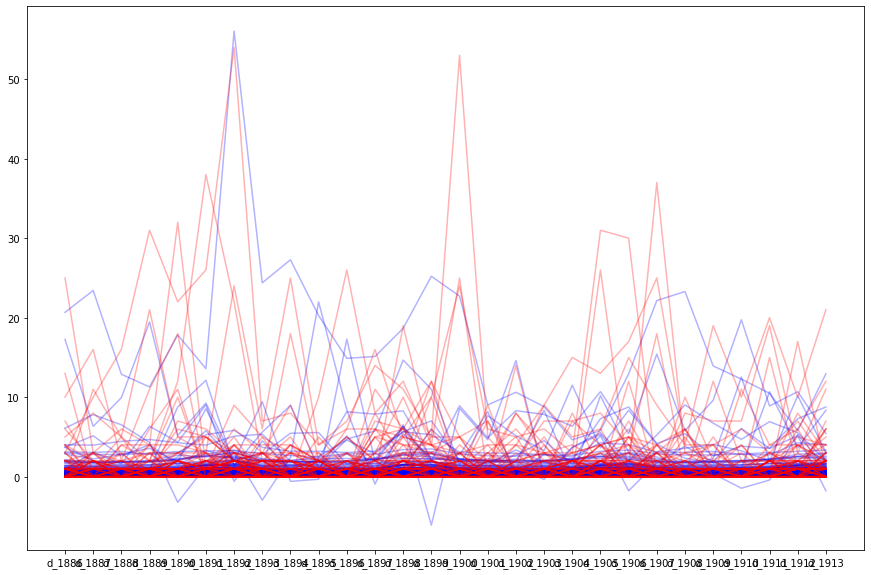

In [16]:
plt.figure(figsize=(15,10))
_ = plt.plot(valid_preds.T.iloc[:,:100], color='blue', alpha=0.3)
_ = plt.plot(valid_fold_df.T.iloc[:,:100], color='red', alpha=0.3)

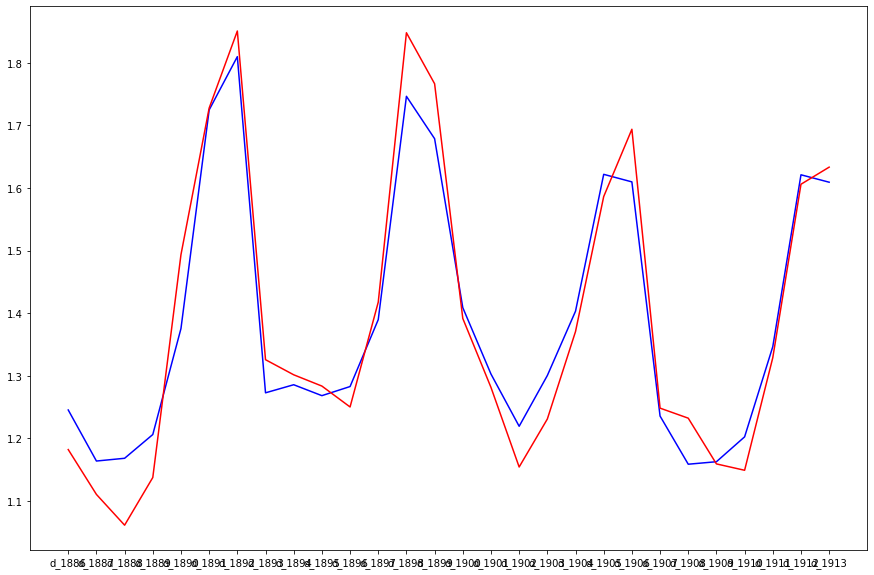

In [17]:
plt.figure(figsize=(15,10))
_ = plt.plot(valid_preds.T.mean(axis=1), color='blue')
_ = plt.plot(valid_fold_df.T.mean(axis=1), color='red')

In [18]:
# submission data building
from collections import defaultdict
result = []
val_result = np.hstack(val_result)
test_result = np.hstack(test_result)
for i, col in enumerate(np.hstack(cols_order)):
    result.append(np.hstack([col+'_validation', val_result[i*28:(i+1)*28]]))
    result.append(np.hstack([col+'_evaluation', test_result[i*28:(i+1)*28]]))
result = pd.DataFrame(result)
result.columns = ['id'] + ['F'+str(i) for i in range(1,29)]

In [19]:
submission = smp_submission[['id']].merge(result, how='left', on='id')
submission.to_csv("submission.csv", index=False)